# Processing the capillary force video
Use ffmpeg to export sheets
```sh
ffmpeg -i T-L\ _\ 1-50\ tip-tip.avi 2>&1 |grep -o '[0-9]\+ fps'
# Output is 30 fps
ffmpeg -i T-L\ _\ 1-50\ tip-tip.avi -r 30 output_%04d.png
```

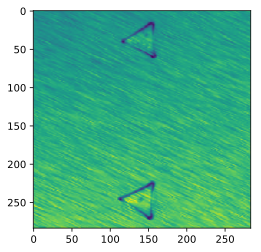

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from skimage import feature, io
im = io.imread('images/output_0001.png', as_grey=True)
imshow(im);

## Noise reduction

In [5]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)

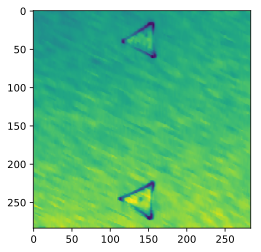

In [6]:
im2=denoise_tv_chambolle(im, weight=0.05, multichannel=True)
imshow(im2);

## Edge detection

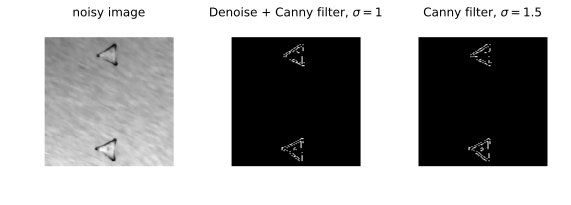

In [7]:
# Compute the Canny filter for two values of sigma
s=[1, 1.5]
edges1 = feature.canny(im2, sigma=s[0])
edges2 = feature.canny(im, sigma=s[1])

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im2, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Denoise + Canny filter, $\sigma={}$'.format(s[0]))

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma={}$'.format(s[1]))

fig.tight_layout()

plt.show()

## Major Axis
The major axis will go through both center of gravity, so it is used to find the connection line. Compute it from covariance matrix.

The major inertia $I_m=2cma^2$, minor inertia $I_M=I_m+\dfrac{md^2}{2}$, so
$$d/2=\sqrt{\frac{I_M-I_m}{2m}}$$

In [41]:
from scipy.sparse import dok_matrix
def topoints(arr):
    b=dok_matrix(arr)
    return array(list(b.keys()))

In [8]:
def covmatrix(edges):
    '''Center of gravity + Covariance Matrix'''
    nx, ny=edges.shape
    n=sum(edges)
    ax=arange(nx)
    ay=arange(ny)
    x=sum(ax[:, newaxis]*edges)/n
    xx=sum(ax[:, newaxis]**2*edges)/n
    y=sum(ay[newaxis, :]*edges)/n
    yy=sum(ay[newaxis, :]**2*edges)/n
    xy=dot(dot(ax, edges), ay)/n
    lxx=xx-x**2
    lyy=yy-y**2
    lxy=xy-x*y
    return n, array([x, y]), array([[lxx, lxy],[lxy, lyy]])

In [26]:
def main_axis(edges):
    '''Diagonalize to find major axis with least eigenval'''
    mass2, center, covm=covmatrix(edges)
    val, vec=eigh(covm)
    idx = val.argsort()  
    val = val[idx]
    vec = vec[:,idx]
    d=sqrt((val[1]-val[0]))
    print(val, d)
    return d, center[::-1], vec[0]

In [32]:
def get_axis(edges, show):
    d, center, slop=main_axis(edges)
    if show:
        imshow(edges)
        p=center+d*slop
        q=center-d*slop
        plot([p[0], q[0]], [p[1],q[1]], 'ro-');
    return slop

In [33]:
def normalize(angle):
    if angle<0:
        angle+=2*pi
    return angle-pi/2
def detect_angle(num, show=False):
    fname='images/output_%04d.png'%num
    im = io.imread(fname, as_grey=True)
    im2=denoise_tv_chambolle(im, weight=0.05, multichannel=True)
    edges = feature.canny(im2, sigma=1.5)
    return normalize(arctan2(*get_axis(edges, show)))

The angle is relative to the right $\rightarrow$ direction

[   171.87788326  10533.69945258] 101.79303301


1.5747324998058385

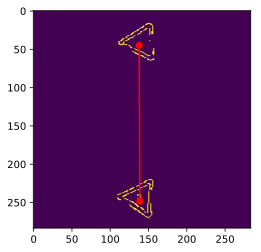

In [37]:
detect_angle(10, show=True)

In [39]:
%time angles=[detect_angle(i+1) for i in range(51)]

[   164.73847266  11031.99303454] 104.246124925
[   172.01972267  10875.71648081] 103.45867174
[   180.7603593   11028.02674355] 104.150210678
[   171.88210624  10888.82620505] 103.522674322
[   171.6661196   10794.90072106] 103.069076844
[   176.90310672  10875.19760761] 103.432560158
[   171.27589009  10680.22641401] 102.513172441
[   173.74787282  10622.42084144] 102.218750573
[   170.22109932  10615.29350083] 102.201136987
[   171.87788326  10533.69945258] 101.79303301
[   174.55188614  10495.35431308] 101.591350158
[   166.96933243  10316.92055528] 100.746966321
[   166.0196663   10279.47993039] 100.565701231
[   174.50178564  10191.51636489] 100.08503674
[   168.81589458  10044.77324707] 99.3778514182
[  163.53246793  9909.70512329] 98.7227058754
[  173.41962812  9903.40084716] 98.6406671664
[  169.67129739  9827.07108538] 98.2720702336
[  175.90199868  9820.74668102] 98.2081701405
[  172.12165485  9650.53027275] 97.3571189893
[  164.74458736  9530.84377129] 96.7786091237
[  173.

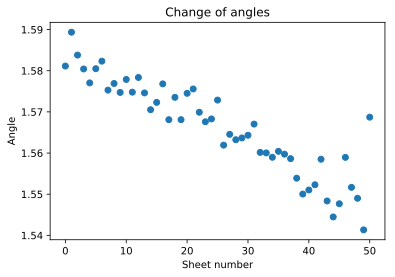

In [40]:
plot(angles, 'o')
title('Change of angles')
xlabel('Sheet number')
ylabel('Angle');